Lets download the required modules


In [0]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint
import nltk
nltk.download('stopwords')

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Lets get the population N=112

In [0]:
from google.colab import files
uploaded = files.upload()

Saving coronapatents.xlsx to coronapatents.xlsx


Unnamed: 3  is the patent files


In [0]:
df=pd.read_excel('coronapatents.xlsx')

In [0]:
df

,Unnamed: 0,PAT. NO.,Title,Unnamed: 3
0,1,10548971,MERS-CoV vaccine,"( 1 of 112 )\nUnited States Patent 10,548,971\nWeiner , et al. February 4, 2020\nMERS-CoV va..."
1,2,10538558,Inhibition of TCR signaling with peptide variants,"( 2 of 112 )\nUnited States Patent 10,538,558\nSigalov January 21, 2020\nInhibition of TCR sig..."
2,3,10434168,Attenuated bovine coronavirus and related vaccines,"( 3 of 112 )\nUnited States Patent 10,434,168\nPeters , et al. October 8, 2019\nAttenuated b..."
3,4,10434116,Methods of treating coronavirus infection,"( 4 of 112 )\nUnited States Patent 10,434,116\nFrieman , et al. October 8, 2019\nMethods of ..."
4,5,10421802,Human monoclonal antibodies against the middle east respiratory syndrome coronavirus (MERS-CoV) ...,"( 5 of 112 )\nUnited States Patent 10,421,802\nDimitrov , et al. September 24, 2019\nHuman m..."
...,...,...,...,...
107,108,5419907,Pathogenic porcine respiratory coronavirus,"( 108 of 112 )\nUnited States Patent 5,419,907\nPaul , et al. May 30, 1995\n**Please see ima..."
108,109,5369026,DNA encoding bovine coronavirus polypeptides E2 and E3,"( 109 of 112 )\nUnited States Patent 5,369,026\nParker , et al. November 29, 1994\nDNA encod..."
109,110,5244922,Methods for treating viral infections,"( 110 of 112 )\nUnited States Patent 5,244,922\nBurzynski September 14, 1993\nMethods for trea..."
110,111,5047238,Adjuvants for vaccines,"( 111 of 112 )\nUnited States Patent 5,047,238\nAcree , et al. September 10, 1991\nAdjuvants..."


Lets clean the patent documents

In [0]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df['Unnamed: 3'].values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['of', 'united', 'states', 'patent', 'weiner', 'et', 'al', 'february', 'mers', 'cov', 'vaccine', 'abstract', 'disclosed', 'herein', 'is', 'vaccine', 'comprising', 'middle', 'east', 'respiratory', 'syndrome', 'coronavirus', 'mers', 'cov', 'antigen', 'the', 'antigen', 'can', 'be', 'consensus', 'antigen', 'the', 'consensus', 'antigen', 'can', 'be', 'consensus', 'spike', 'antigen', 'also', 'disclosed', 'herein', 'is', 'method', 'of', 'treating', 'subject', 'in', 'need', 'thereof', 'by', 'administering', 'the', 'vaccine', 'to', 'the', 'subject', 'inventors', 'weiner', 'david', 'merion', 'pa', 'muthumani', 'karuppiah', 'cherry', 'hill', 'nj', 'sardesai', 'niranjan', 'blue', 'bell', 'pa', 'applicant', 'name', 'city', 'state', 'country', 'type', 'the', 'trustees', 'of', 'the', 'university', 'of', 'pennsylvania', 'inovio', 'pharmaceuticals', 'inc', 'philadelphia', 'plymouth', 'meeting', 'pa', 'pa', 'us', 'us', 'assignee', 'the', 'trustees', 'of', 'the', 'university', 'of', 'pennsylvania', 'phi

In [0]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
# or do
# !conda install -c conda-forge spacy-model-en_core_web_md 
# and use nlp=spacy.load('en_core_web_sm') instead in below function.
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [0]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.058*"cite" + 0.032*"cell" + 0.021*"virus" + 0.019*"peptide" + '
  '0.017*"antibody" + 0.011*"bind" + 0.011*"wherein" + 0.009*"applicant" + '
  '0.009*"wo" + 0.009*"treat"'),
 (1,
  '0.056*"sub" + 0.029*"group" + 0.017*"select" + 0.015*"compound" + '
  '0.014*"consist" + 0.013*"virus" + 0.011*"method" + 0.009*"infection" + '
  '0.009*"invention" + 0.008*"include"'),
 (2,
  '0.037*"vaccine" + 0.033*"virus" + 0.028*"cell" + 0.015*"inactivate" + '
  '0.014*"degree" + 0.011*"ccv" + 0.011*"invention" + 0.010*"fluid" + '
  '0.009*"add" + 0.009*"hour"'),
 (3,
  '0.034*"sequence" + 0.022*"protein" + 0.021*"acid" + 0.020*"invention" + '
  '0.018*"virus" + 0.016*"seq" + 0.015*"comprise" + 0.015*"nucleic" + '
  '0.011*"present" + 0.011*"method"')]


In [0]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.8771,"sequence, protein, acid, invention, virus, seq, comprise, nucleic, present, method","[vaccine, disclose, vaccine, comprise, disclose, treat, thereof, administer, vaccine, inventor, ..."
1,1,0.0,0.8831,"cite, cell, virus, peptide, antibody, bind, wherein, applicant, wo, treat","[inhibition, signal, peptide, variant, abstract, present, invention, provide, composition, compr..."
2,2,3.0,0.6883,"sequence, protein, acid, invention, virus, seq, comprise, nucleic, present, method","[attenuate, bovine, relate, vaccine, abstract, present, invention, disclose, novel, attenuate, b..."
3,3,0.0,0.4430,"cite, cell, virus, peptide, antibody, bind, wherein, applicant, wo, treat","[method, treat, infection, abstract, present, invention, provide, method, treat, infection, exam..."
4,4,0.0,0.5042,"cite, cell, virus, peptide, antibody, bind, wherein, applicant, wo, treat","[dimitrov, antibody, mer, engineer, bispecific, fusion, inhibitory, peptide, abstract, invention..."
5,5,3.0,0.5251,"sequence, protein, acid, invention, virus, seq, comprise, nucleic, present, method","[antibody, protein, abstract, present, invention, provide, monoclonal, antibody, bind, mer, spik..."
6,6,0.0,0.6164,"cite, cell, virus, peptide, antibody, bind, wherein, applicant, wo, treat","[antiviral, composition, comprise, sulfated, polysaccharide, abstract, present, invention, provi..."
7,7,1.0,0.4560,"sub, group, select, compound, consist, virus, method, infection, invention, include","[prevention, treatment, disease, induce, virus, present, invention, provide, taurine, prevention..."
8,8,3.0,0.5615,"sequence, protein, acid, invention, virus, seq, comprise, nucleic, present, method","[antibodie, method, induce, mer, provide, several, embodiment, protective, inhibit, prevent, mer..."
9,9,3.0,0.7361,"sequence, protein, acid, invention, virus, seq, comprise, nucleic, present, method","[antigen, disclose, embodiment, method, collect, extract, elute, protein, antigen, cell, infect,..."


In [0]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.8831,"cite, cell, virus, peptide, antibody, bind, wherein, applicant, wo, treat","[inhibition, signal, peptide, variant, abstract, present, invention, provide, composition, compr..."
1,1.0,0.9991,"sub, group, select, compound, consist, virus, method, infection, invention, include","[dithiin, activity, compound, useful, anti, infective, agent, well, method, describe, compound, ..."
2,2.0,0.9852,"vaccine, virus, cell, inactivate, degree, ccv, invention, fluid, add, hour","[acree, vaccine, abstract, parenterally, administer, inactivate, vaccine, provide, systemic, pro..."
3,3.0,0.9995,"sequence, protein, acid, invention, virus, seq, comprise, nucleic, present, method","[image, certificate, correction, human, virus, cause, respiratory, tract, infection, thereof, ab..."


In [0]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

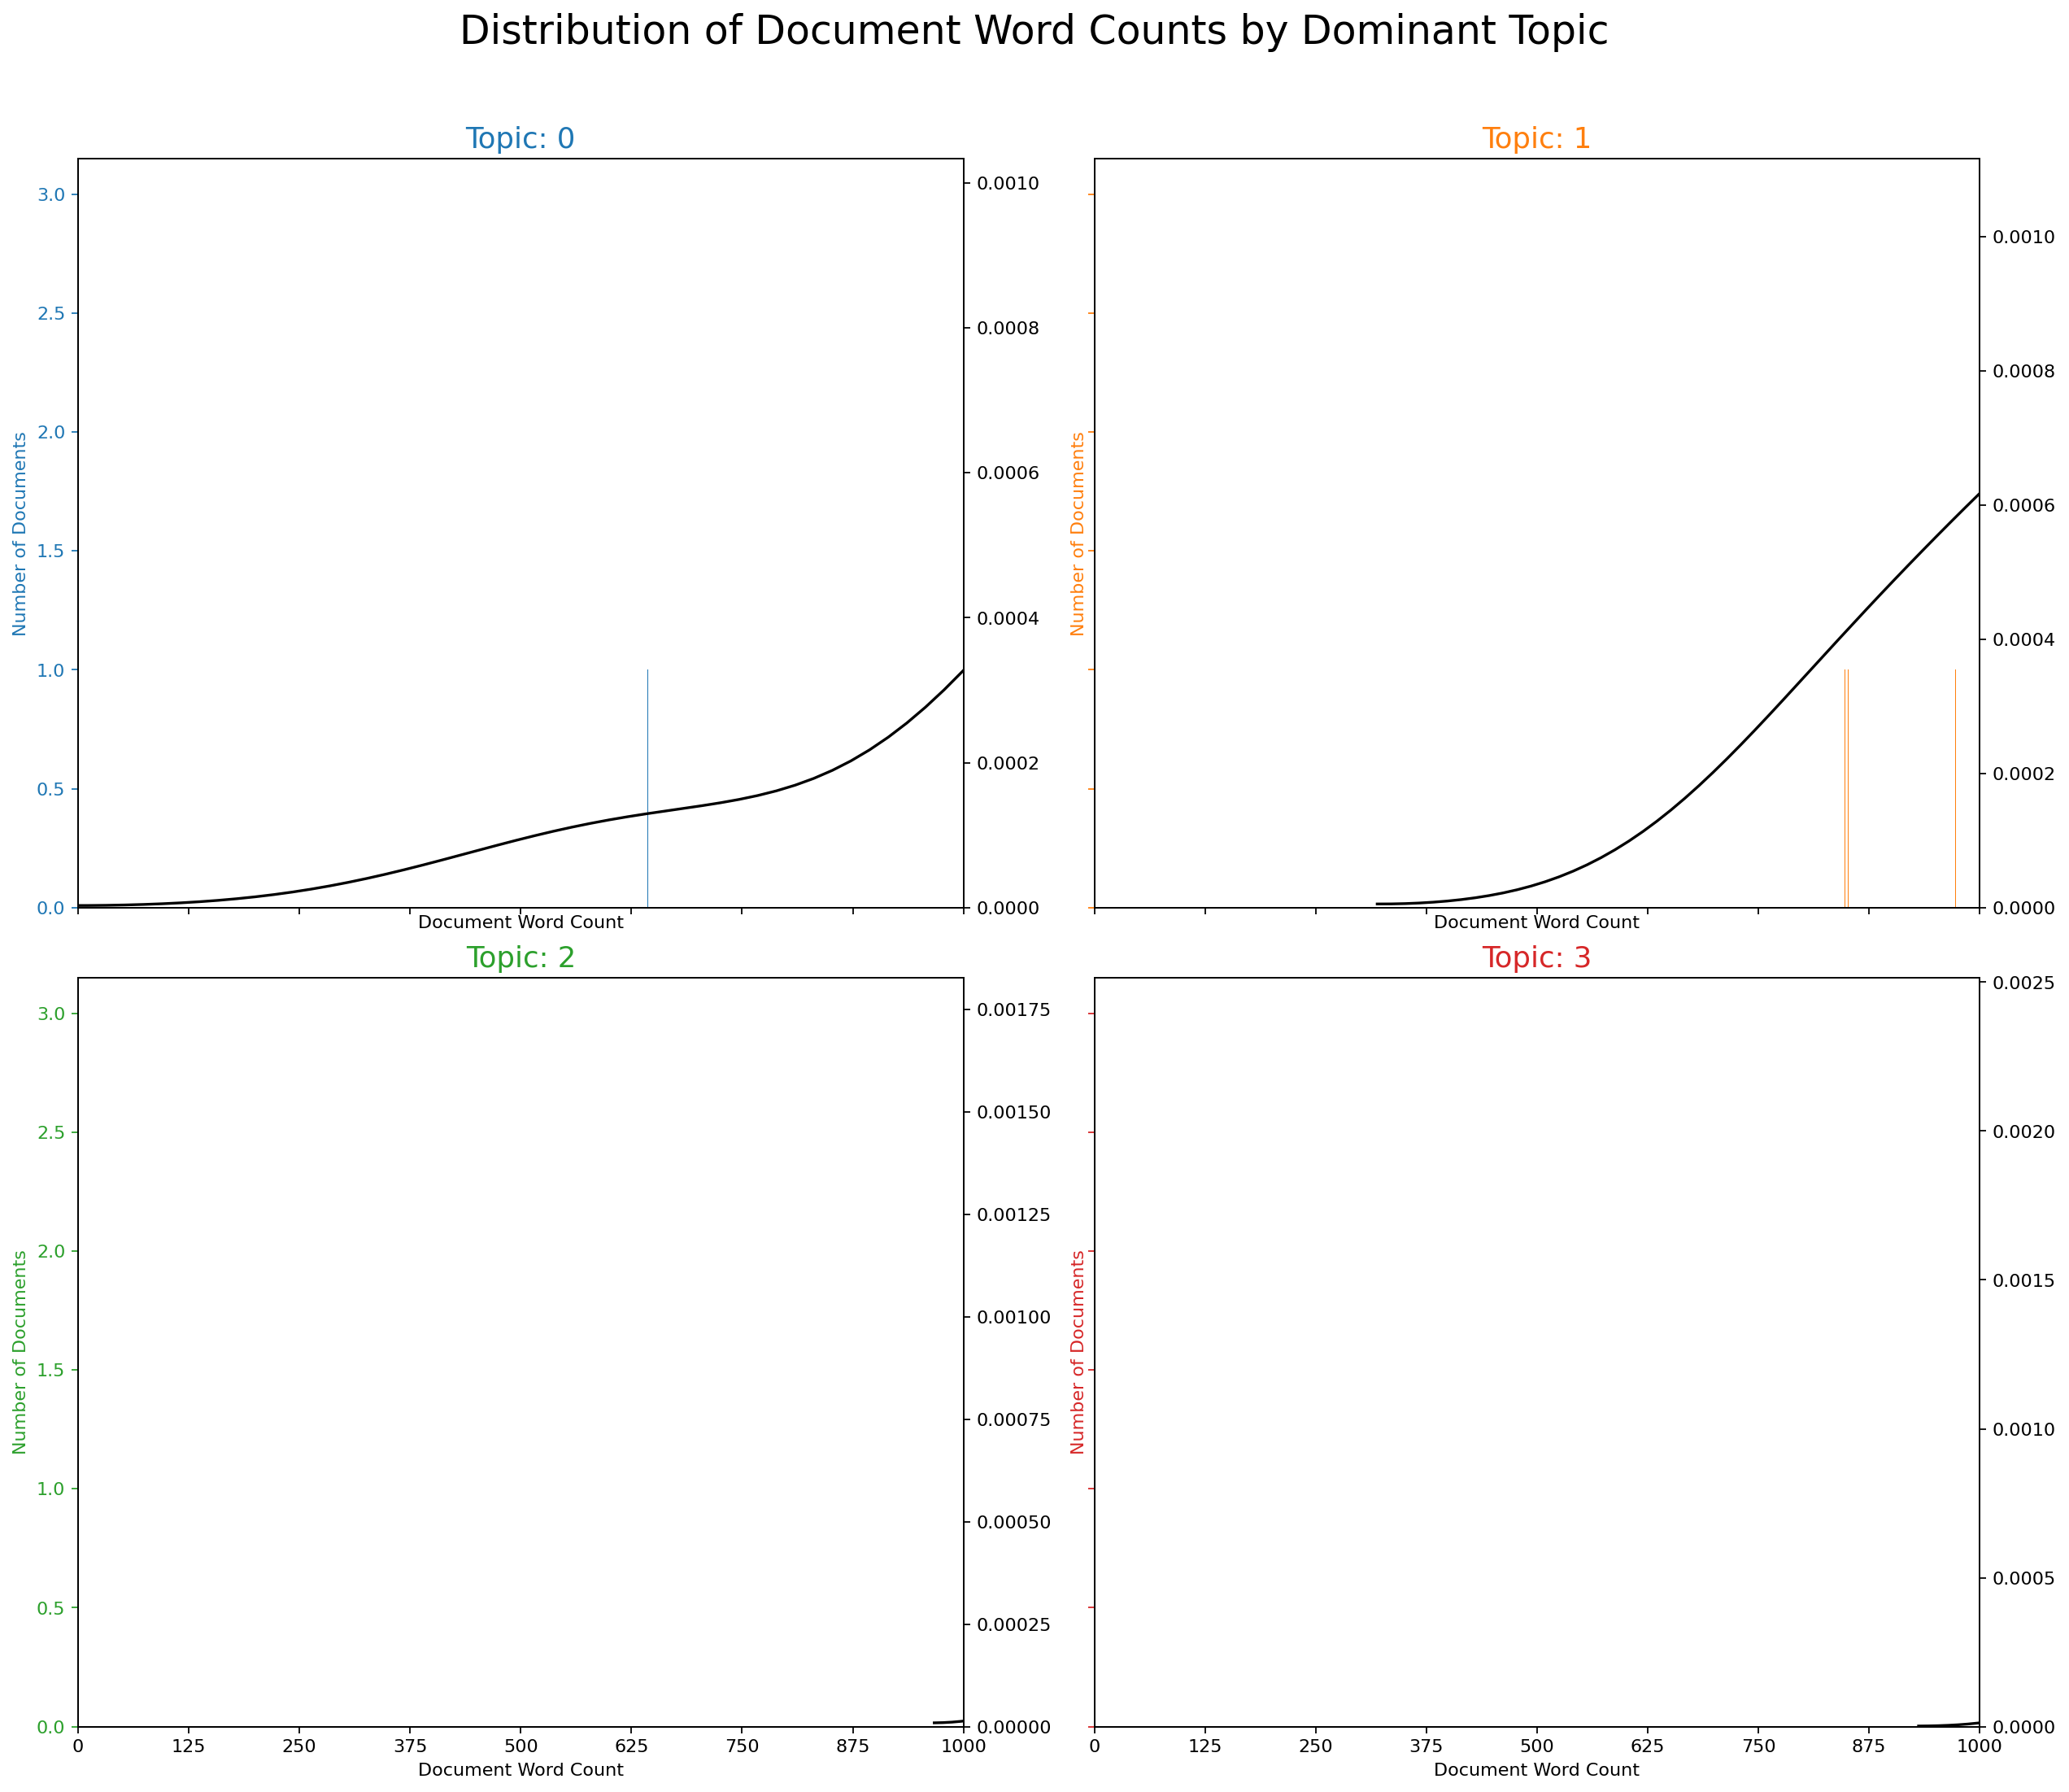

In [0]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

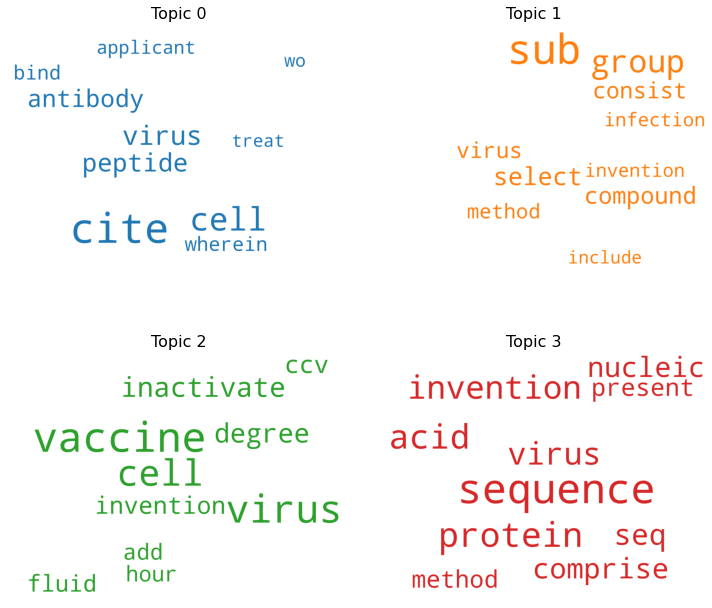

In [0]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

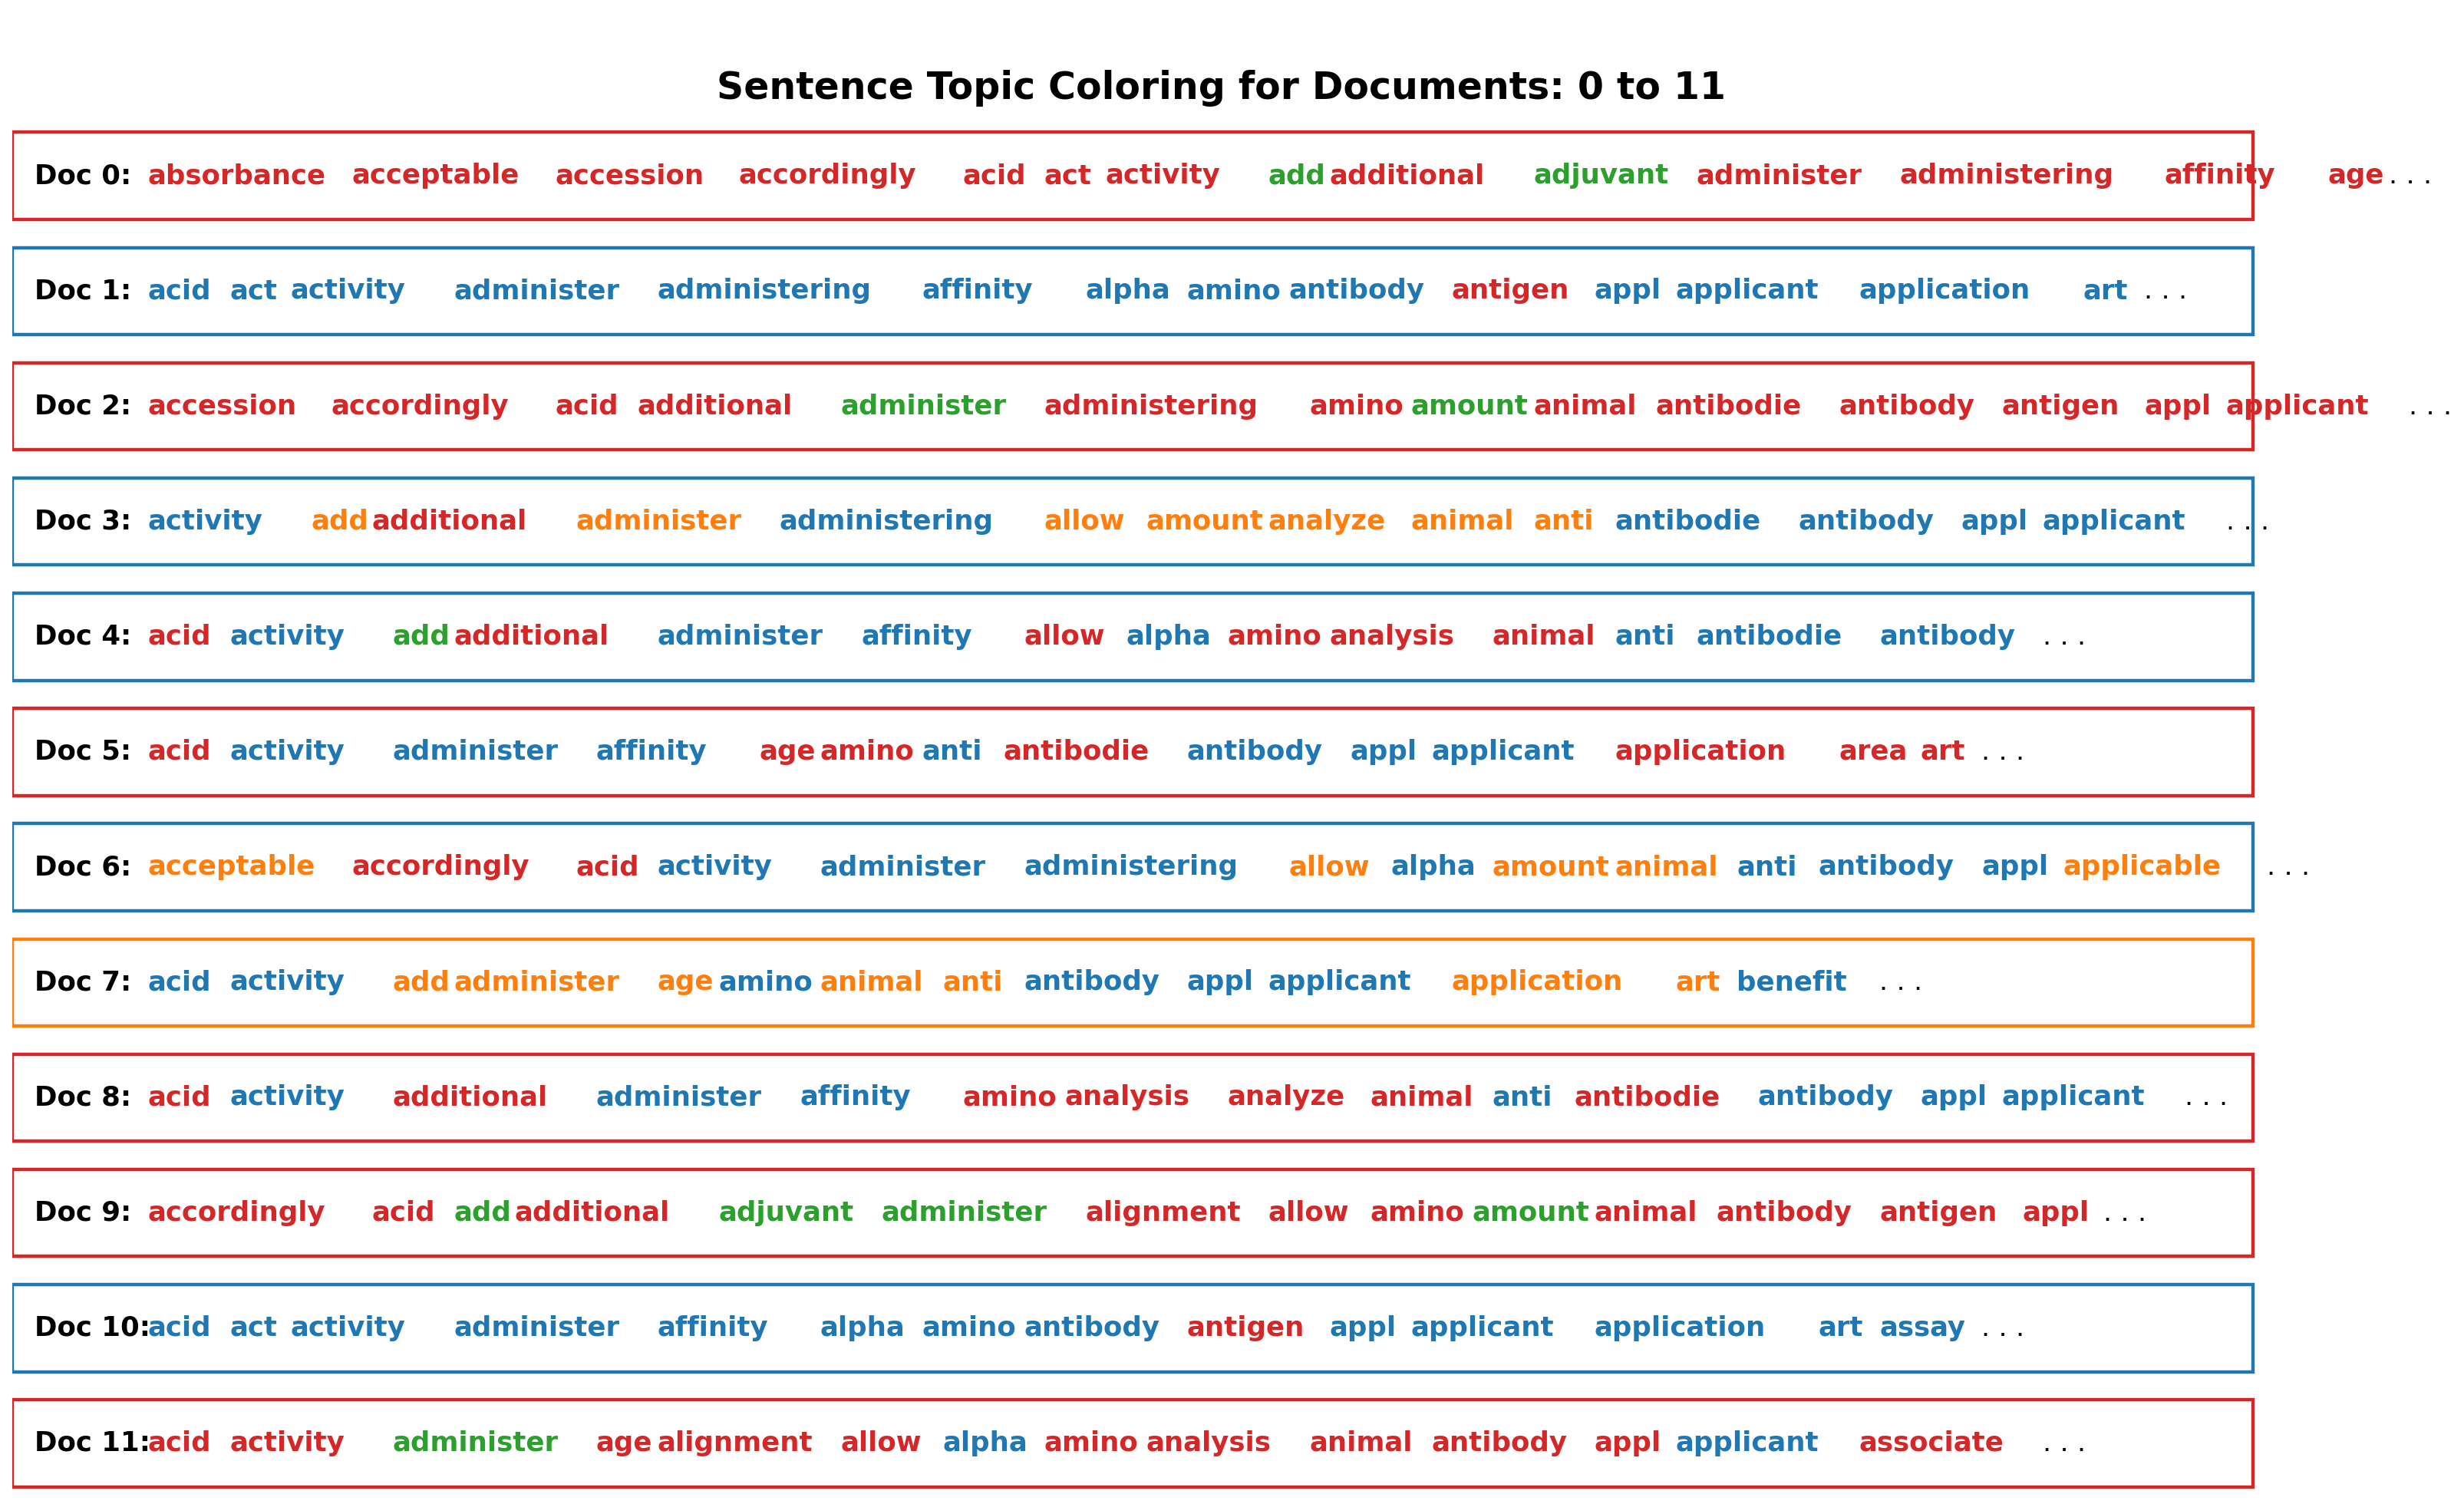

In [0]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()    

In [0]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

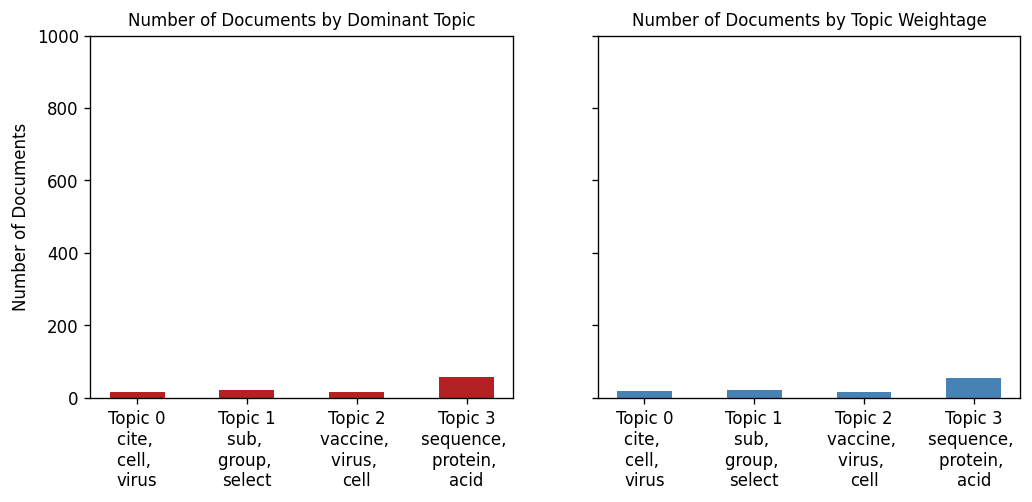

In [0]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

In [0]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 112 samples in 0.000s...
[t-SNE] Computed neighbors for 112 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 112 / 112
[t-SNE] Mean sigma: 0.338165
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.711578
[t-SNE] KL divergence after 1000 iterations: 0.123175


In [0]:
df_dominant_topic['Text']

0      [vaccine, disclose, vaccine, comprise, disclose, treat, thereof, administer, vaccine, inventor, ...
1      [inhibition, signal, peptide, variant, abstract, present, invention, provide, composition, compr...
2      [attenuate, bovine, relate, vaccine, abstract, present, invention, disclose, novel, attenuate, b...
3      [method, treat, infection, abstract, present, invention, provide, method, treat, infection, exam...
4      [dimitrov, antibody, mer, engineer, bispecific, fusion, inhibitory, peptide, abstract, invention...
                                                      ...                                                 
107    [image, certificate, correction, respiratory, abstract, present, invention, provide, biologicall...
108    [dna, encode, bovine, polypeptide, code, sequence, material, produce, protein, provide, antigeni...
109    [method, treat, viral, infection, abstract, present, invention, provide, method, treat, viral, d...
110    [acree, vaccine, abstract, par

In [0]:
df_dominant_topic['Text2']=df_dominant_topic['Text']. astype(str)

In [0]:
df_dominant_topic['processed'] = df_dominant_topic['Text2'].map(lambda x: re.sub('[,\.!?]', '', x))
df_dominant_topic['processed']=df_dominant_topic['processed'].map(lambda x: x.lower())

ERROR! Session/line number was not unique in database. History logging moved to new session 62


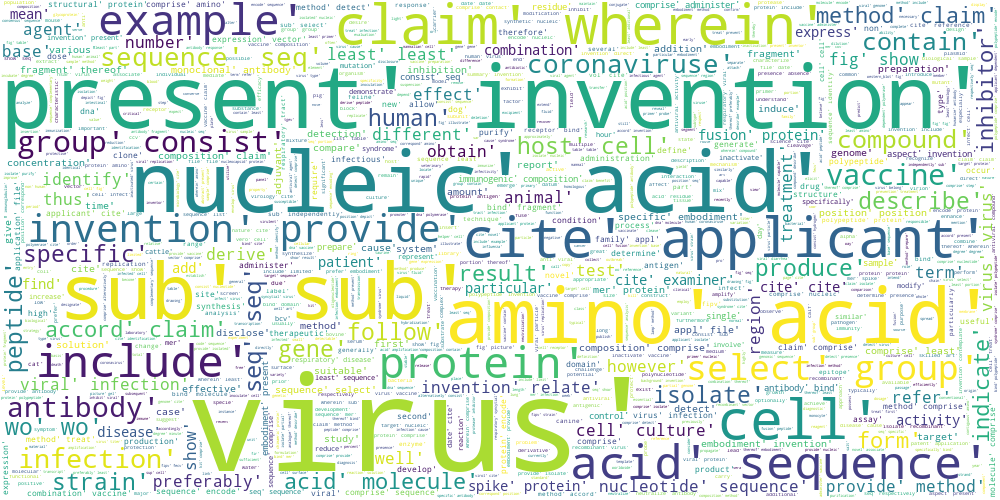

In [0]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(df_dominant_topic['processed'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue', width=1000, height=500 )
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

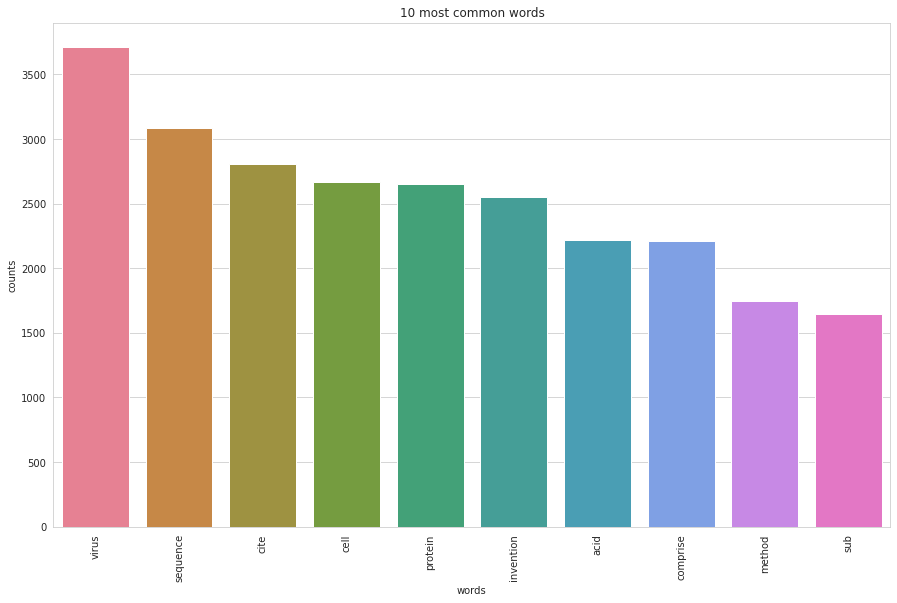

In [0]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(df_dominant_topic['processed'])
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

In [0]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 112
number_words = 10
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
zwille exogenous exemplified exemplify exert exfoliate exhaustion exhaustive exhibit exist

Topic #1:
zwille exogenous exemplified exemplify exert exfoliate exhaustion exhaustive exhibit exist

Topic #2:
sequence stage outbreak early group position invention present nucleotide strain

Topic #3:
zwille exogenous exemplified exemplify exert exfoliate exhaustion exhaustive exhibit exist

Topic #4:
feline position amino correspond fipv depict protein fecv spike cat

Topic #5:
seq peptide protein fig region invention cell fusion cite antiviral

Topic #6:
zwille exogenous exemplified exemplify exert exfoliate exhaustion exhaustive exhibit exist

Topic #7:
pro residue sup fig site substrate gly sequence domain structure

Topic #8:
applicant cite isolate protein genome polymerase dependent partial bat wo

Topic #9:
protein mer sequence fig antibody comprise seq cite vector claim

Topic #10:
cell sample detect virus method treat comprise cite second type

Topic 